In [1]:
import os
from tensorflow.keras.optimizers import Adam
from keras.metrics import mse
import matplotlib.pyplot as plt
from keras.backend import set_session
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import Model
import numpy as np
from tensorflow.keras.layers import Conv2D, BatchNormalization, ZeroPadding2D, UpSampling2D, Input, Lambda, multiply, Input, concatenate
from keras.layers import LeakyReLU
from PIL import Image
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import numpy as np

# Load the image
def generate_bw_image(img_path):
  img = cv2.imread(img_path)
  print(img.shape)
  w,h,_ = img.shape
  # Define the coordinates of the region to be removed
  x1, y1 = w//2, h//3  # Top-left corner
  x2, y2 = w//2+50, h//3 + 50  # Bottom-right corner

  # Create a mask that covers the region of interest
  mask = np.zeros(img.shape[:2], dtype=np.uint8)
  cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)

  # Apply the mask to the image to remove the region
  result = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))

  # Save the result
  cv2.imwrite('mask.png', result)

# from google.colab import drive

# drive.mount('/content/gdrive/MyDrive')

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
def ChangeImage(image, dim=32):
    x_cutting = image.size[0] - image.size[0] % dim
    y_cutting = image.size[1] - image.size[1] % dim

    a = (image.size[0] - x_cutting) // 2
    b = (image.size[1] - y_cutting) // 2
    c = (image.size[0] + x_cutting) // 2
    d = (image.size[1] + y_cutting) // 2

    cropped_image = img_to_array(image.crop([a,b,c,d]))
    cropped_image = (np.expand_dims(cropped_image, axis=0).astype('float32'))/255
    return cropped_image

In [7]:

class Hourglass:
    def __init__(self, input_size, input_channel, output_channel, nu, nd, ns, ku, kd, ks, upsample_type='bilinear'):
        self.in_size = input_size
        self.in_channel = input_channel
        self.out_channel = output_channel
        self.nu = nu
        self.nd = nd
        self.ns = ns
        self.ku = ku
        self.kd = kd
        self.ks = ks
        self.upsample_type = upsample_type
        self.use_bias = True

    def up_sample(self, x, size=2):
        index = x.shape
        new_w = int(round(index[1] * size))
        new_h = int(round(index[2] * size))
        return tf.image.resize(x, [new_w, new_h], method=tf.image.ResizeMethod.BILINEAR)

    def down(self, x, n, k, use_bias=True):
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=2, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x

    
    def skip(self, x, n, k, use_bias=True):
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x

    def up(self, x, n, k, upsample_mode, use_bias=True):
        x = BatchNormalization()(x)
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2D(n, 1, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = self.up_sample(x, 2)
        return x
    
    def model_structure(self):
        width, height = self.in_size
        input = Input((width, height, self.in_channel))
        x = input
        n = 5
        skips = []
        x = self.down(x, self.nd[0], self.kd[0], self.use_bias)
        if self.ns[0] != 0:
            skip = self.skip(x, self.ns[0], self.ks[0], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[1], self.kd[1], self.use_bias)
        if self.ns[1] != 0:
            skip = self.skip(x, self.ns[1], self.ks[1], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[2], self.kd[2], self.use_bias)
        if self.ns[2] != 0:
            skip = self.skip(x, self.ns[2], self.ks[2], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[3], self.kd[3], self.use_bias)
        if self.ns[3] != 0:
            skip = self.skip(x, self.ns[3], self.ks[3], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[4], self.kd[4], self.use_bias)
        if self.ns[4] != 0:
            skip = self.skip(x, self.ns[4], self.ks[4], self.use_bias)
            skips.append(skip)

        x = self.up(x, self.nu[4], self.ku[4], self.upsample_type, self.use_bias)
        skips = skips[::-1]
        x = self.up(x, self.nu[3], self.ku[3],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[2]], axis=-1)
        x = self.up(x, self.nu[2], self.ku[2],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[3]], axis=-1)
        x = self.up(x, self.nu[1], self.ku[1],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[4]], axis=-1)
        x = self.up(x, self.nu[0], self.ku[0],self.upsample_type, self.use_bias)

        output = Conv2D(self.out_channel, 1, activation='sigmoid')(x)

        model = Model(inputs=input, outputs=output)
        return model

In [8]:
def plot_losses(train_loss, image_title):
    plt.figure(figsize=(8, 6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(image_title)
    # plt.figure(figsize=(10,10))
    plt.plot(train_loss, label='Train Loss')
    plt.legend()
    plt.show()

In [9]:
import os
import glob

folder_path = "./drive/MyDrive/SMAI_Project"  

file_list = []
for file_path in glob.glob(os.path.join(folder_path, "*")):
    file_list.append(file_path)
print(file_list)

['./drive/MyDrive/SMAI_Project/bridge.png', './drive/MyDrive/SMAI_Project/lenna.png', './drive/MyDrive/SMAI_Project/coastguard.png', './drive/MyDrive/SMAI_Project/zebra.png', './drive/MyDrive/SMAI_Project/baboon.png', './drive/MyDrive/SMAI_Project/barbara.png', './drive/MyDrive/SMAI_Project/man.png', './drive/MyDrive/SMAI_Project/foreman.png', './drive/MyDrive/SMAI_Project/ppt3.png', './drive/MyDrive/SMAI_Project/face.png', './drive/MyDrive/SMAI_Project/pepper.png', './drive/MyDrive/SMAI_Project/flowers.png', './drive/MyDrive/SMAI_Project/comic.png', './drive/MyDrive/SMAI_Project/monarch.png']


In [11]:
def model_obj(x):
  b, w, h, c = x.shape

  ### build model
  layers = Hourglass((w, h), input_channel, c,
                        nu=[128, 128, 128, 128, 128],
                        nd=[128, 128, 128, 128, 128],
                        ns=[4, 4, 4, 4, 128],
                        ku=[3, 3, 3, 3, 3],
                        kd=[3, 3, 3, 3, 3],
                        ks=[1, 1, 1, 1, 1],
                        upsample_type='bilinear'
                        )
  
  return layers

(512, 512, 3)

---------------------------bridge---------------------------


iteration no.: 0 ,loss : 0.021485
iteration no.: 500 ,loss : 0.001491
iteration no.: 1000 ,loss : 0.001080
iteration no.: 1500 ,loss : 0.000896
iteration no.: 2000 ,loss : 0.000802
iteration no.: 2500 ,loss : 0.000749
iteration no.: 3000 ,loss : 0.000710
iteration no.: 3500 ,loss : 0.000655
iteration no.: 4000 ,loss : 0.000634
iteration no.: 4500 ,loss : 0.000622
iteration no.: 5000 ,loss : 0.000575
iteration no.: 5500 ,loss : 0.000565
iteration no.: 6000 ,loss : 0.000554
iteration no.: 6500 ,loss : 0.000536
iteration no.: 7000 ,loss : 0.000528
iteration no.: 7500 ,loss : 0.000523
iteration no.: 8000 ,loss : 0.000503


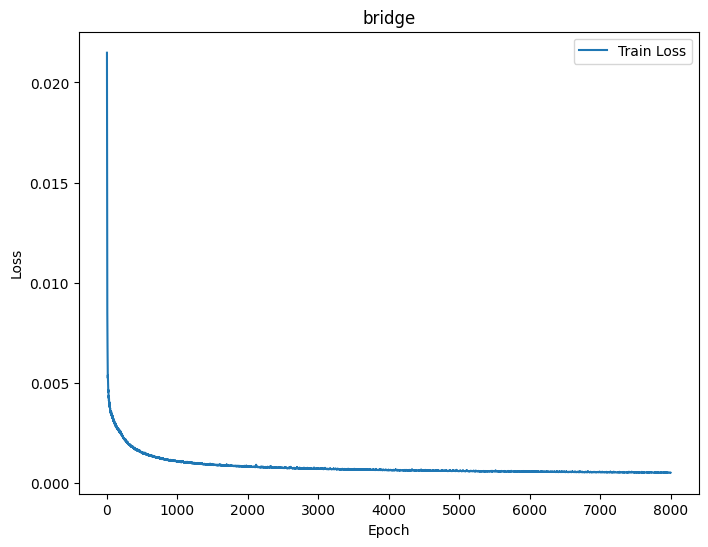

(512, 512, 3)

---------------------------lenna---------------------------


iteration no.: 0 ,loss : 0.023871
iteration no.: 500 ,loss : 0.000573
iteration no.: 1000 ,loss : 0.000401
iteration no.: 1500 ,loss : 0.000317
iteration no.: 2000 ,loss : 0.000273
iteration no.: 2500 ,loss : 0.000238
iteration no.: 3000 ,loss : 0.000220
iteration no.: 3500 ,loss : 0.000205
iteration no.: 4000 ,loss : 0.000194
iteration no.: 4500 ,loss : 0.000183
iteration no.: 5000 ,loss : 0.000184
iteration no.: 5500 ,loss : 0.000171
iteration no.: 6000 ,loss : 0.000169
iteration no.: 6500 ,loss : 0.000163
iteration no.: 7000 ,loss : 0.000152
iteration no.: 7500 ,loss : 0.000150
iteration no.: 8000 ,loss : 0.000146


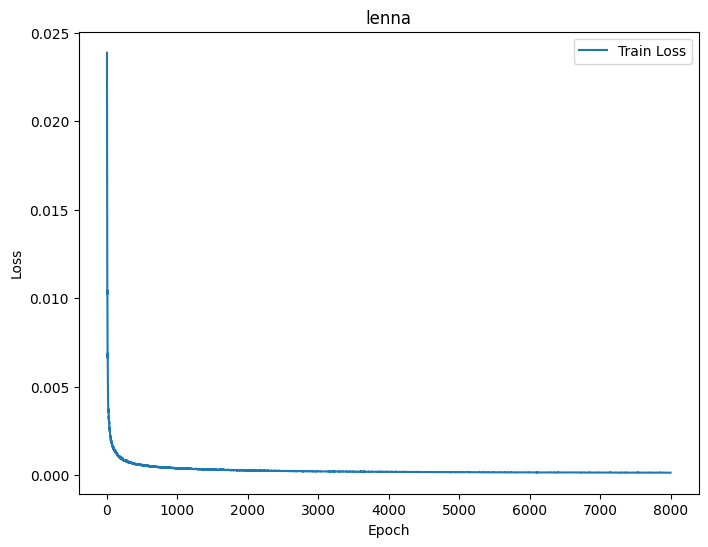

(288, 352, 3)

---------------------------coastguard---------------------------


iteration no.: 0 ,loss : 0.015452
iteration no.: 500 ,loss : 0.000917
iteration no.: 1000 ,loss : 0.000724
iteration no.: 1500 ,loss : 0.000635
iteration no.: 2000 ,loss : 0.000572
iteration no.: 2500 ,loss : 0.000522
iteration no.: 3000 ,loss : 0.000478
iteration no.: 3500 ,loss : 0.000459
iteration no.: 4000 ,loss : 0.000438
iteration no.: 4500 ,loss : 0.000426
iteration no.: 5000 ,loss : 0.000456
iteration no.: 5500 ,loss : 0.000404
iteration no.: 6000 ,loss : 0.000388
iteration no.: 6500 ,loss : 0.000376
iteration no.: 7000 ,loss : 0.000368
iteration no.: 7500 ,loss : 0.000368
iteration no.: 8000 ,loss : 0.000425


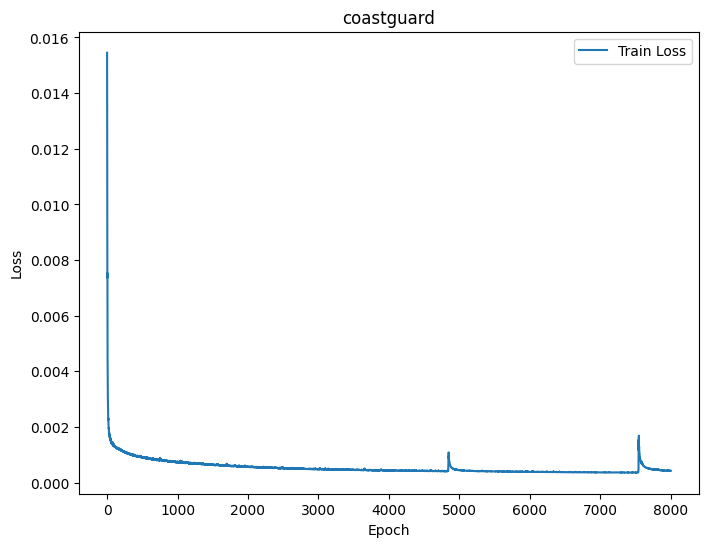

(391, 586, 3)

---------------------------zebra---------------------------


iteration no.: 0 ,loss : 0.013250
iteration no.: 500 ,loss : 0.001352
iteration no.: 1000 ,loss : 0.000830
iteration no.: 1500 ,loss : 0.000639
iteration no.: 2000 ,loss : 0.000520
iteration no.: 2500 ,loss : 0.000461
iteration no.: 3000 ,loss : 0.000400
iteration no.: 3500 ,loss : 0.000368
iteration no.: 4000 ,loss : 0.000341
iteration no.: 4500 ,loss : 0.000313
iteration no.: 5000 ,loss : 0.000296
iteration no.: 5500 ,loss : 0.000283
iteration no.: 6000 ,loss : 0.000273
iteration no.: 6500 ,loss : 0.000260
iteration no.: 7000 ,loss : 0.000252
iteration no.: 7500 ,loss : 0.000241
iteration no.: 8000 ,loss : 0.000233


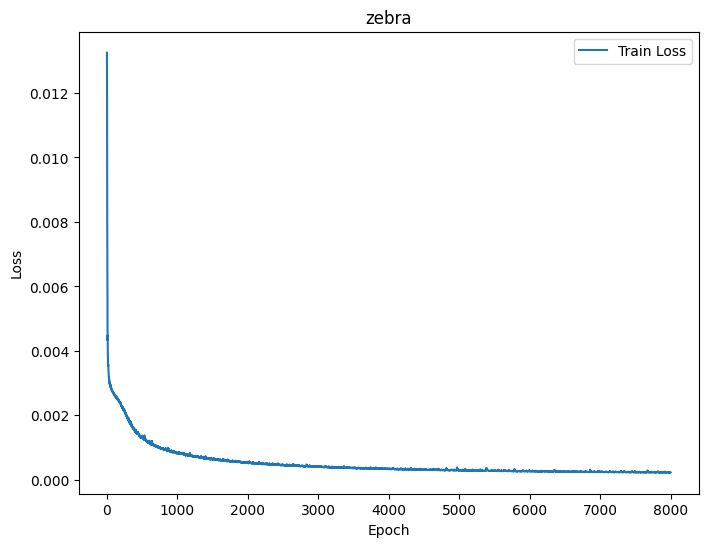

(480, 500, 3)

---------------------------baboon---------------------------


iteration no.: 0 ,loss : 0.023077
iteration no.: 500 ,loss : 0.001849
iteration no.: 1000 ,loss : 0.001594
iteration no.: 1500 ,loss : 0.001441
iteration no.: 2000 ,loss : 0.001329
iteration no.: 2500 ,loss : 0.001243
iteration no.: 3000 ,loss : 0.001188
iteration no.: 3500 ,loss : 0.001135
iteration no.: 4000 ,loss : 0.001095
iteration no.: 4500 ,loss : 0.001058
iteration no.: 5000 ,loss : 0.001023
iteration no.: 5500 ,loss : 0.000998
iteration no.: 6000 ,loss : 0.000973
iteration no.: 6500 ,loss : 0.000946
iteration no.: 7000 ,loss : 0.000924
iteration no.: 7500 ,loss : 0.000914
iteration no.: 8000 ,loss : 0.000898


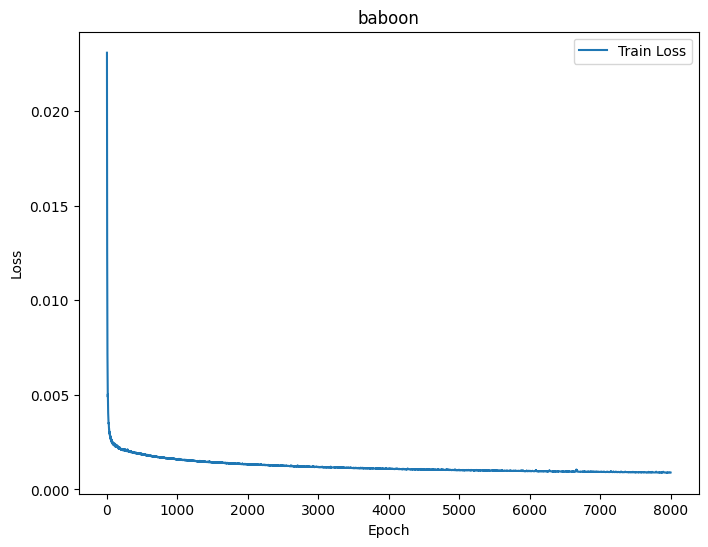

(576, 720, 3)

---------------------------barbara---------------------------


iteration no.: 0 ,loss : 0.017378
iteration no.: 500 ,loss : 0.001384
iteration no.: 1000 ,loss : 0.001020
iteration no.: 1500 ,loss : 0.000876
iteration no.: 2000 ,loss : 0.000813
iteration no.: 2500 ,loss : 0.000749
iteration no.: 3000 ,loss : 0.000699
iteration no.: 3500 ,loss : 0.000656
iteration no.: 4000 ,loss : 0.000633
iteration no.: 4500 ,loss : 0.000611
iteration no.: 5000 ,loss : 0.000599
iteration no.: 5500 ,loss : 0.000588
iteration no.: 6000 ,loss : 0.000572
iteration no.: 6500 ,loss : 0.000566
iteration no.: 7000 ,loss : 0.000549
iteration no.: 7500 ,loss : 0.000551
iteration no.: 8000 ,loss : 0.000533


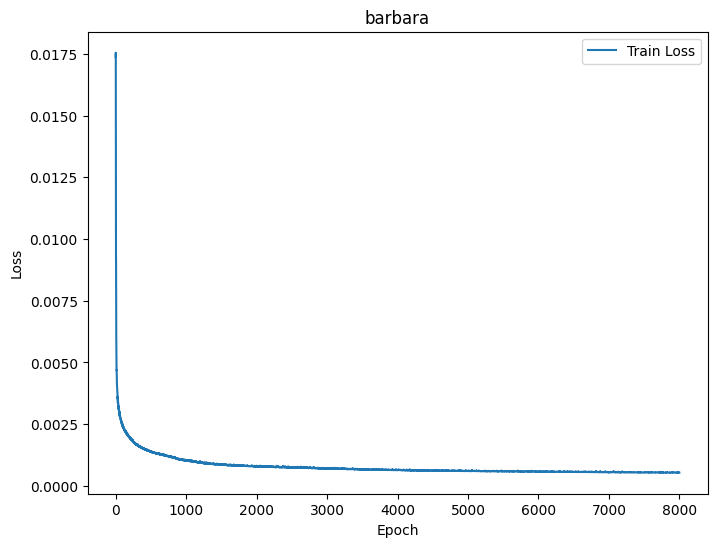

(512, 512, 3)

---------------------------man---------------------------


iteration no.: 0 ,loss : 0.010675
iteration no.: 500 ,loss : 0.000796
iteration no.: 1000 ,loss : 0.000572
iteration no.: 1500 ,loss : 0.000475
iteration no.: 2000 ,loss : 0.000415
iteration no.: 2500 ,loss : 0.000394
iteration no.: 3000 ,loss : 0.000353
iteration no.: 3500 ,loss : 0.000331
iteration no.: 4000 ,loss : 0.000321
iteration no.: 4500 ,loss : 0.000306
iteration no.: 5000 ,loss : 0.000287
iteration no.: 5500 ,loss : 0.000294
iteration no.: 6000 ,loss : 0.000276
iteration no.: 6500 ,loss : 0.000271
iteration no.: 7000 ,loss : 0.000257
iteration no.: 7500 ,loss : 0.000553
iteration no.: 8000 ,loss : 0.000373


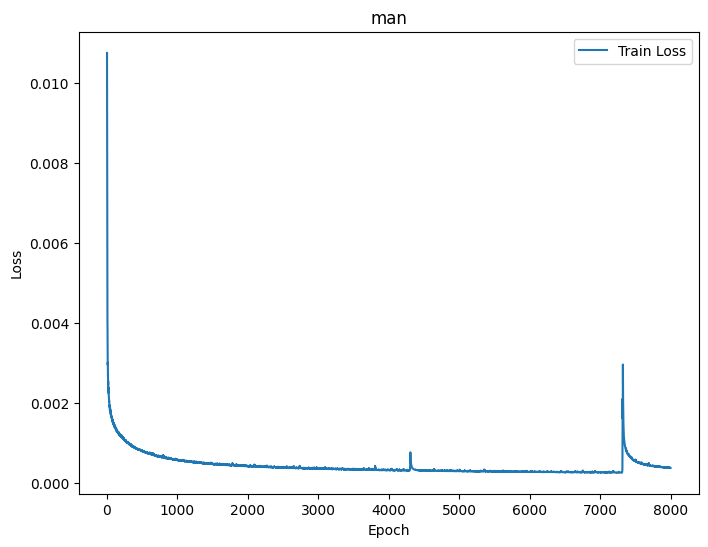

(288, 352, 3)

---------------------------foreman---------------------------


iteration no.: 0 ,loss : 0.099541
iteration no.: 500 ,loss : 0.001058
iteration no.: 1000 ,loss : 0.000524
iteration no.: 1500 ,loss : 0.000388
iteration no.: 2000 ,loss : 0.000339
iteration no.: 2500 ,loss : 0.000300
iteration no.: 3000 ,loss : 0.000286
iteration no.: 3500 ,loss : 0.000277
iteration no.: 4000 ,loss : 0.000248
iteration no.: 4500 ,loss : 0.000235
iteration no.: 5000 ,loss : 0.000227
iteration no.: 5500 ,loss : 0.000225
iteration no.: 6000 ,loss : 0.000220
iteration no.: 6500 ,loss : 0.000216
iteration no.: 7000 ,loss : 0.000202
iteration no.: 7500 ,loss : 0.000201
iteration no.: 8000 ,loss : 0.000193


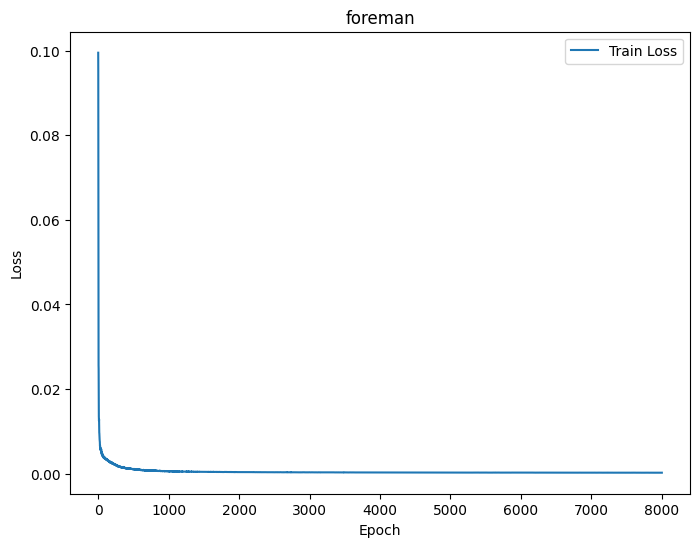

(656, 529, 3)

---------------------------ppt3---------------------------


iteration no.: 0 ,loss : 0.153048
iteration no.: 500 ,loss : 0.002641
iteration no.: 1000 ,loss : 0.001798
iteration no.: 1500 ,loss : 0.001416
iteration no.: 2000 ,loss : 0.001193
iteration no.: 2500 ,loss : 0.000980
iteration no.: 3000 ,loss : 0.000810
iteration no.: 3500 ,loss : 0.000708
iteration no.: 4000 ,loss : 0.000627
iteration no.: 4500 ,loss : 0.000575
iteration no.: 5000 ,loss : 0.000500
iteration no.: 5500 ,loss : 0.000461
iteration no.: 6000 ,loss : 0.000440
iteration no.: 6500 ,loss : 0.000406
iteration no.: 7000 ,loss : 0.000417
iteration no.: 7500 ,loss : 0.000399
iteration no.: 8000 ,loss : 0.000368


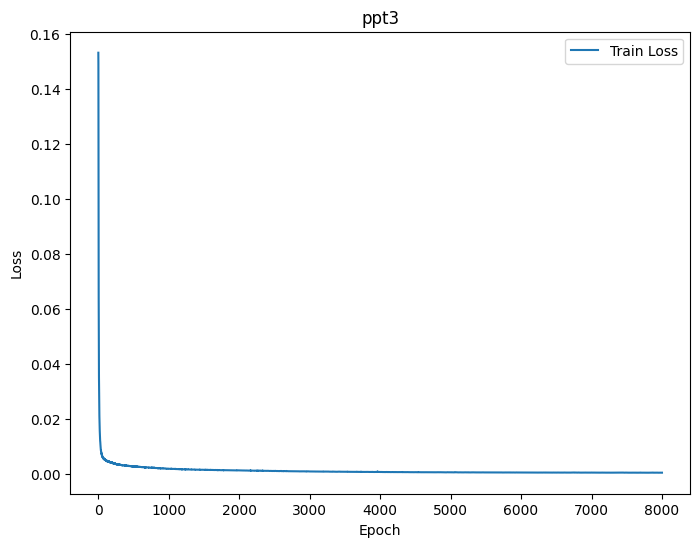

(276, 276, 3)

---------------------------face---------------------------


iteration no.: 0 ,loss : 0.009548
iteration no.: 500 ,loss : 0.000279
iteration no.: 1000 ,loss : 0.000252
iteration no.: 1500 ,loss : 0.000224
iteration no.: 2000 ,loss : 0.000209
iteration no.: 2500 ,loss : 0.000201
iteration no.: 3000 ,loss : 0.000192
iteration no.: 3500 ,loss : 0.000188
iteration no.: 4000 ,loss : 0.000184
iteration no.: 4500 ,loss : 0.000177
iteration no.: 5000 ,loss : 0.000171
iteration no.: 5500 ,loss : 0.000169
iteration no.: 6000 ,loss : 0.000166
iteration no.: 6500 ,loss : 0.000164
iteration no.: 7000 ,loss : 0.000162
iteration no.: 7500 ,loss : 0.000158
iteration no.: 8000 ,loss : 0.000155


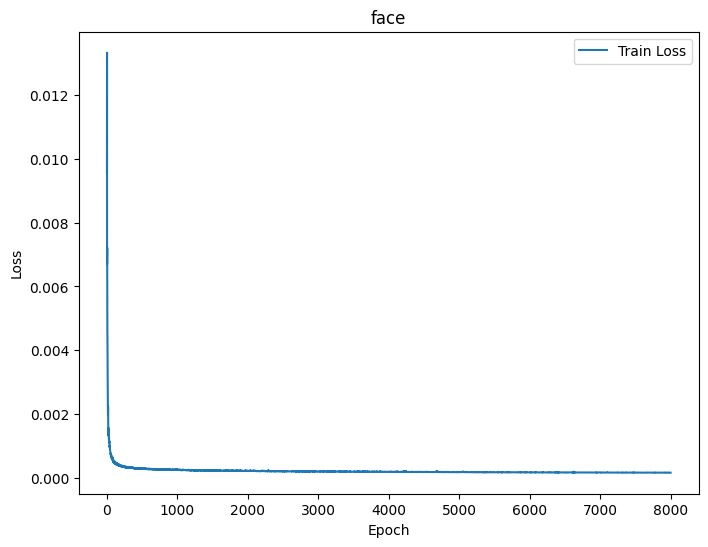

(512, 512, 3)

---------------------------pepper---------------------------


iteration no.: 0 ,loss : 0.025416
iteration no.: 500 ,loss : 0.000560
iteration no.: 1000 ,loss : 0.000359
iteration no.: 1500 ,loss : 0.000283
iteration no.: 2000 ,loss : 0.000250
iteration no.: 2500 ,loss : 0.000219
iteration no.: 3000 ,loss : 0.000204
iteration no.: 3500 ,loss : 0.000190
iteration no.: 4000 ,loss : 0.000188
iteration no.: 4500 ,loss : 0.000174
iteration no.: 5000 ,loss : 0.000177
iteration no.: 5500 ,loss : 0.000161
iteration no.: 6000 ,loss : 0.000161
iteration no.: 6500 ,loss : 0.000155
iteration no.: 7000 ,loss : 0.000154
iteration no.: 7500 ,loss : 0.000148
iteration no.: 8000 ,loss : 0.000149


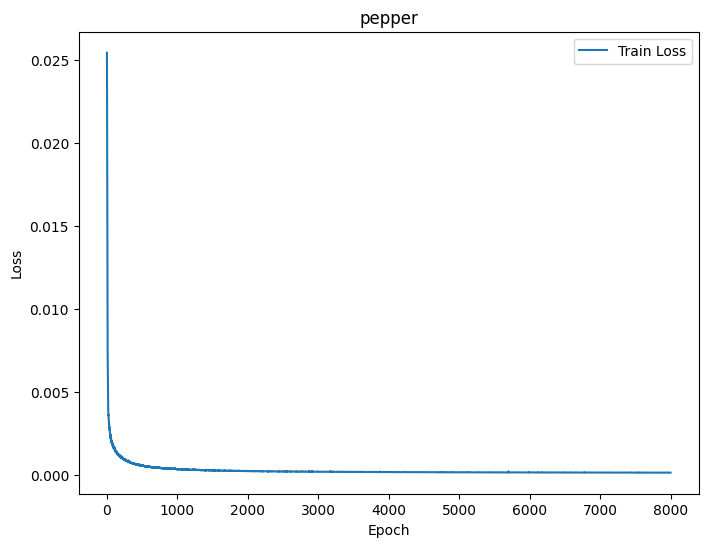

(362, 500, 3)

---------------------------flowers---------------------------


iteration no.: 0 ,loss : 0.021792
iteration no.: 500 ,loss : 0.001323
iteration no.: 1000 ,loss : 0.000879
iteration no.: 1500 ,loss : 0.000727
iteration no.: 2000 ,loss : 0.000612
iteration no.: 2500 ,loss : 0.000522
iteration no.: 3000 ,loss : 0.000485
iteration no.: 3500 ,loss : 0.000431
iteration no.: 4000 ,loss : 0.000424
iteration no.: 4500 ,loss : 0.000379
iteration no.: 5000 ,loss : 0.000358
iteration no.: 5500 ,loss : 0.000340
iteration no.: 6000 ,loss : 0.000317
iteration no.: 6500 ,loss : 0.001185
iteration no.: 7000 ,loss : 0.000667
iteration no.: 7500 ,loss : 0.000551
iteration no.: 8000 ,loss : 0.000497


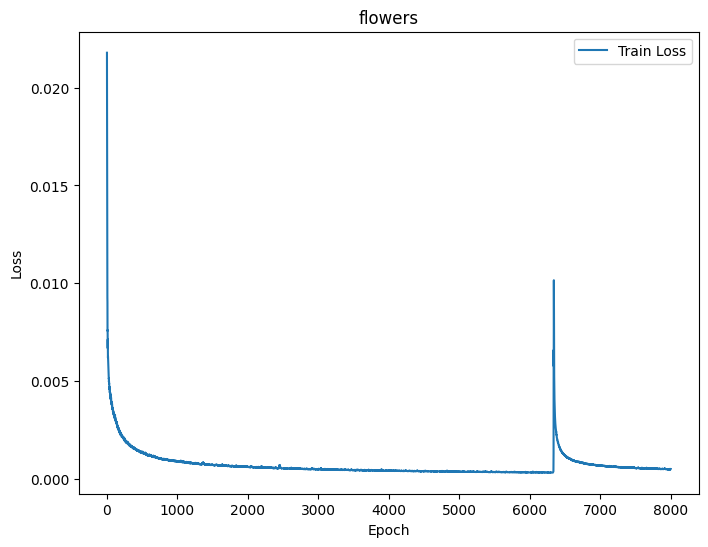

(361, 250, 3)

---------------------------comic---------------------------


iteration no.: 0 ,loss : 0.060514
iteration no.: 500 ,loss : 0.003326
iteration no.: 1000 ,loss : 0.002523
iteration no.: 1500 ,loss : 0.002083
iteration no.: 2000 ,loss : 0.001803
iteration no.: 2500 ,loss : 0.001608
iteration no.: 3000 ,loss : 0.001498
iteration no.: 3500 ,loss : 0.001385
iteration no.: 4000 ,loss : 0.001302
iteration no.: 4500 ,loss : 0.001242
iteration no.: 5000 ,loss : 0.001199
iteration no.: 5500 ,loss : 0.001136
iteration no.: 6000 ,loss : 0.001083
iteration no.: 6500 ,loss : 0.001085
iteration no.: 7000 ,loss : 0.001022
iteration no.: 7500 ,loss : 0.001000
iteration no.: 8000 ,loss : 0.000977


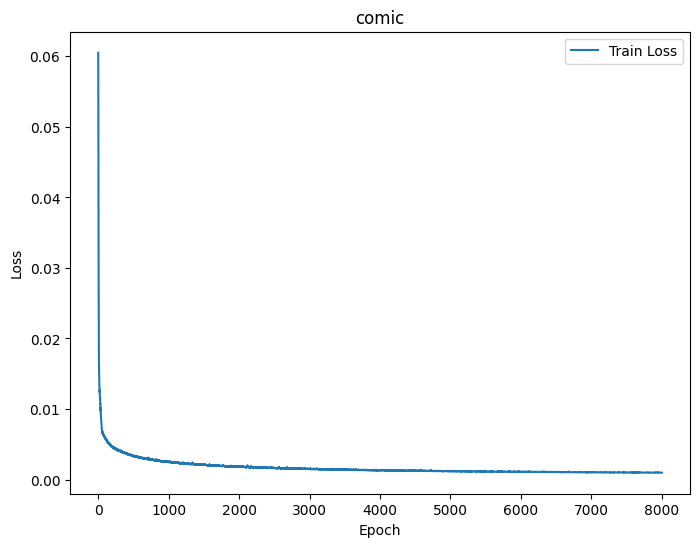

(512, 768, 3)

---------------------------monarch---------------------------


iteration no.: 0 ,loss : 0.015969
iteration no.: 500 ,loss : 0.001034
iteration no.: 1000 ,loss : 0.000505
iteration no.: 1500 ,loss : 0.000342
iteration no.: 2000 ,loss : 0.000276
iteration no.: 2500 ,loss : 0.000227
iteration no.: 3000 ,loss : 0.000197
iteration no.: 3500 ,loss : 0.000186
iteration no.: 4000 ,loss : 0.000177
iteration no.: 4500 ,loss : 0.000161
iteration no.: 5000 ,loss : 0.000148
iteration no.: 5500 ,loss : 0.000144
iteration no.: 6000 ,loss : 0.000141
iteration no.: 6500 ,loss : 0.000134
iteration no.: 7000 ,loss : 0.000132
iteration no.: 7500 ,loss : 0.000132
iteration no.: 8000 ,loss : 0.000127


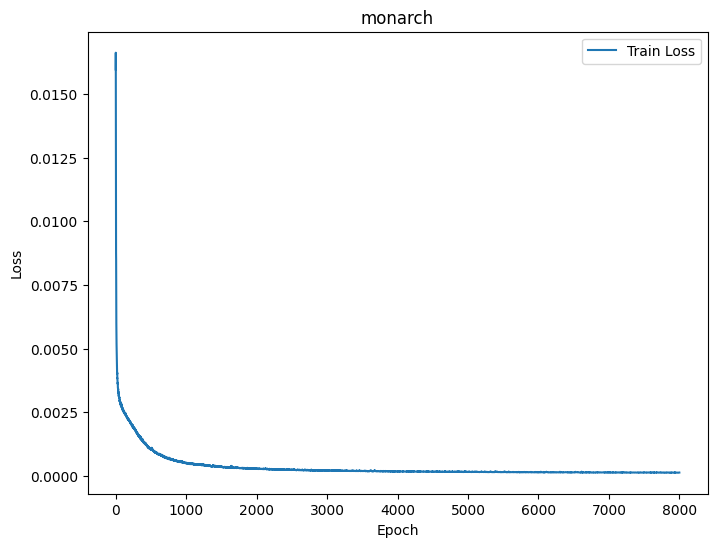

In [12]:
image_mask = "mask.png"

for image in file_list:

  
  sigma = 1. / 30
  method = 'random'
  input_channel = 3
  num_iter = 8000
  lr = 0.01

  ### load data
  img = load_img(image)
  w,h = img.size 
  x = ChangeImage(img)
  generate_bw_image(image)
  
  mask = load_img(image_mask)
  mask = ChangeImage(mask)
  # x = add_noise(x,25 / 255.)
  words = image.split('/')
  imm = words[-1].split('.')[0]
  full_path = './drive/MyDrive/SMAI_Project/{}'.format(imm)
  try:
    os.mkdir(full_path) 
  except OSError as error: 
    print(error)  
  # os.mkdir(imm)
  print("\n---------------------------{}---------------------------".format(imm))
  original = x * mask
  array_to_img(original[0]).save('{}/noise.png'.format(full_path))
  # array_to_img(original[0]).save('{}/noise.png'.format(full_path))
  layers = model_obj(original)
  b, w, h, c = original.shape
  mod = layers.model_structure()
  #----------------------------------------------------------
  input = mod.input
  mask_input = Input((w, h, c))
  y = mod.output
  output = multiply([y, mask_input])
  model = Model(inputs=[input, mask_input], outputs=output,name='trainer')
#----------------------------------------------------------
  model.compile(optimizer=Adam(lr=lr), loss=mse)
  # model.summary()

  train_loss = []
  z = np.random.uniform(0, 0.1, size=(1,w,h,input_channel))
  losses = []
  for i in range(num_iter+1):
      with tf.device('/GPU:0'):
        temp = z + np.random.normal(0, sigma, size = z.shape)
        loss = model.train_on_batch([temp, mask], original)
        train_loss.append(loss)
        if i % 500 == 0:
            print('iteration no.: %d ,loss : %f' % (i, loss))
            y = mod.predict_on_batch(z)
            array_to_img(y[0]).save('{}/{}.png'.format(full_path, i))

  plot_losses(train_loss, imm)